# 1. Imports and Device Setup

This cell imports all required modules for data handling, model building, training, and evaluation. It also sets up the device (GPU or CPU) for PyTorch computations.


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. EarlyStopping and FocalLoss

This cell defines two utility classes:
- `EarlyStopping` for halting training when validation loss stops improving, preventing overfitting.
- `FocalLoss`, a custom loss function that helps address class imbalance by focusing the model more on hard-to-classify examples.



In [2]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# 3. Data Transforms, Datasets, and Weighted Sampler

This cell sets up data augmentation and normalization for training and validation/test datasets. 
It also constructs PyTorch `ImageFolder` datasets and uses a weighted random sampler to address class imbalance during training.


In [3]:
from sklearn.utils.class_weight import compute_class_weight

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.2),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "knee"
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transform)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transform)

# Compute class weights for loss
targets = [label for _, label in train_ds]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Weighted sampler for DataLoader
weights = 1. / np.bincount(targets)
sample_weights = [weights[label] for label in targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)
class_names = train_ds.classes


# 4. Improved Model Definition

This cell defines the neural network architecture for KL grade classification. 
It uses a ResNet34 backbone for feature extraction and a custom classifier head with dropout and batch normalization for better generalization.


In [4]:
class KLClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(KLClassifier, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

model = KLClassifier(num_classes=5).to(device)


c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5. Loss, Optimizer, and Scheduler

Here we set up the loss function (Focal Loss for class imbalance), optimizer (AdamW for regularization), 
and a learning rate scheduler that reduces the learning rate when validation accuracy plateaus.


In [5]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


c:\uni\idp\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 6. Training Loop with Mixed Precision and Early Stopping

This function handles the training process, including:
- Mixed precision for faster training,
- Early stopping to avoid overfitting,
- Learning rate scheduling,
- Tracking and printing of training/validation accuracy and loss.


In [6]:
def train_model(model, train_loader, val_loader, epochs=25, patience=7):
    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        scheduler.step(val_loss)
        early_stopping(val_loss)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Loss: {train_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet_model.pth")
            print("✅ Model saved.")

        if early_stopping.early_stop:
            print(f"⛔ Early stopping triggered at epoch {epoch+1}.")
            break
    return history


# 7. Train the Model

This cell runs the training function and stores the training history for later visualization.


In [7]:
history = train_model(model, train_loader, val_loader, epochs=25)


Epoch 1/25 → Train Acc: 0.4012, Val Acc: 0.2760, Loss: 0.8227
✅ Model saved.
Epoch 2/25 → Train Acc: 0.5393, Val Acc: 0.3414, Loss: 0.4896
✅ Model saved.
Epoch 3/25 → Train Acc: 0.5772, Val Acc: 0.3947, Loss: 0.4336
✅ Model saved.
Epoch 4/25 → Train Acc: 0.5966, Val Acc: 0.4758, Loss: 0.3966
✅ Model saved.
Epoch 5/25 → Train Acc: 0.6189, Val Acc: 0.3705, Loss: 0.3736
Epoch 6/25 → Train Acc: 0.6334, Val Acc: 0.4116, Loss: 0.3400
Epoch 7/25 → Train Acc: 0.6352, Val Acc: 0.3923, Loss: 0.3370
Epoch 8/25 → Train Acc: 0.6499, Val Acc: 0.5339, Loss: 0.3295
✅ Model saved.
Epoch 9/25 → Train Acc: 0.6494, Val Acc: 0.4952, Loss: 0.3261
Epoch 10/25 → Train Acc: 0.6748, Val Acc: 0.3971, Loss: 0.2998
Epoch 11/25 → Train Acc: 0.6732, Val Acc: 0.4407, Loss: 0.3118
Epoch 12/25 → Train Acc: 0.6748, Val Acc: 0.5000, Loss: 0.2987
Epoch 13/25 → Train Acc: 0.7042, Val Acc: 0.5484, Loss: 0.2651
✅ Model saved.
Epoch 14/25 → Train Acc: 0.7115, Val Acc: 0.5521, Loss: 0.2602
✅ Model saved.
Epoch 15/25 → Train Ac

# 8. Plot Accuracy & Loss

This cell visualizes the training and validation accuracy and loss curves over epochs, 
helping to diagnose overfitting or underfitting.


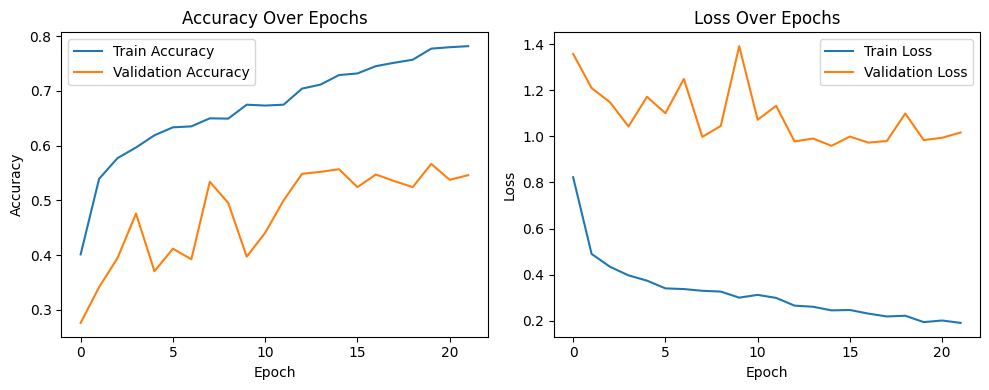

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 9. Load Best Model and Evaluate on Test Set

This cell loads the best model weights (based on validation accuracy) and evaluates the model on the test set, 
printing a classification report with precision, recall, and F1-score for each class.


In [9]:
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


C:\Users\surya\AppData\Local\Temp\ipykernel_17536\3728320835.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet_model.pth"))



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.51      0.61       639
           1       0.28      0.57      0.38       296
           2       0.67      0.51      0.58       447
           3       0.78      0.83      0.80       223
           4       0.83      0.86      0.85        51

    accuracy                           0.57      1656
   macro avg       0.66      0.66      0.64      1656
weighted avg       0.66      0.57      0.59      1656



# 10. Confusion Matrix

This cell plots a confusion matrix for the test set predictions, 
providing a visual summary of which classes are most often confused by the model.


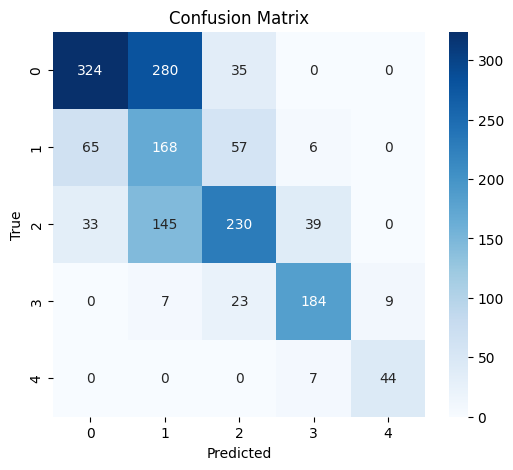

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# 11. Test-Time Augmentation Prediction Function

This function applies test-time augmentation (TTA) to an input image, 
averaging predictions across several augmented versions to increase prediction robustness.


In [11]:
from PIL import Image
import torch.nn.functional as F

def predict_grade(model, image_path, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_index = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_index].item()
    predicted_class = class_names[predicted_index]
    print(f"🔍 Predicted KL Grade: {predicted_class} (Confidence: {confidence:.2%})")
    return predicted_class, confidence


# 12. Single Image Prediction Example

This function demonstrates how to use the trained model to predict the KL grade for a single image, 
displaying the image and the predicted grade with confidence.


In [12]:
# # Cell 12: Single Image Prediction Example
# def predict_knee_grade(model, image_path, class_names, transform):
#     image = Image.open(image_path).convert("RGB")
#     predicted_class, confidence = test_time_augmentation(model, image, transform, num_augmentations=10)
#     print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
#     plt.figure(figsize=(6, 6))
#     plt.imshow(image)
#     plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
#     plt.axis('off')
#     plt.show()
#     return predicted_class, confidence

# # Example usage (uncomment and set your image path):
predict_grade(model, "knee/val/1/9029913R.png", class_names, val_transform)


TypeError: predict_grade() missing 1 required positional argument: 'device'

# 13. Batch Prediction on Directory

This function loops through all images in a directory, 
predicting the KL grade for each and printing the results. 
It can be used to evaluate the model on a batch of new images.


In [ ]:
# # Cell 13: Batch Prediction on Directory
# def predict_directory(model, directory_path, class_names, transform):
#     results = []
#     for filename in os.listdir(directory_path):
#         if filename.endswith(".png") or filename.endswith(".jpg"):
#             image_path = os.path.join(directory_path, filename)
#             print(f"Predicting {filename}...")
#             image = Image.open(image_path).convert("RGB")
#             predicted_class, confidence = test_time_augmentation(model, image, transform)
#             print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
#             results.append({
#                 "filename": filename,
#                 "predicted_class": predicted_class,
#                 "predicted_label": class_names[predicted_class],
#                 "confidence": confidence
#             })
#     results_df = pd.DataFrame(results)
#     return results_df

# # Example usage (uncomment to run):
# results_df = predict_directory(model, "knee/train/1", class_names, val_transform)
# # results_df.to_csv("prediction_results.csv", index=False)


Predicting 9000622L.png...
🔍 Predicted KL Grade: 0 (Confidence: 47.34%)
Predicting 9000622R.png...
🔍 Predicted KL Grade: 1 (Confidence: 44.73%)
Predicting 9001104L.png...
🔍 Predicted KL Grade: 0 (Confidence: 51.41%)
Predicting 9002316L.png...
🔍 Predicted KL Grade: 1 (Confidence: 44.77%)
Predicting 9002316R.png...
🔍 Predicted KL Grade: 1 (Confidence: 48.87%)
Predicting 9003430R.png...
🔍 Predicted KL Grade: 1 (Confidence: 46.88%)
Predicting 9004175L.png...
🔍 Predicted KL Grade: 1 (Confidence: 40.64%)
Predicting 9006723R.png...
🔍 Predicted KL Grade: 0 (Confidence: 47.42%)
Predicting 9008322R.png...
🔍 Predicted KL Grade: 1 (Confidence: 45.57%)
Predicting 9008561L.png...
🔍 Predicted KL Grade: 1 (Confidence: 46.05%)
Predicting 9008561R.png...
🔍 Predicted KL Grade: 1 (Confidence: 46.57%)
Predicting 9012435L.png...
🔍 Predicted KL Grade: 0 (Confidence: 57.94%)
Predicting 9012435R.png...
🔍 Predicted KL Grade: 0 (Confidence: 49.55%)
Predicting 9013634L.png...
🔍 Predicted KL Grade: 1 (Confidence: 

KeyboardInterrupt: 